In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
from PIL import Image
from loguru import logger
from sklearn.model_selection import train_test_split

In [ ]:
DATASET_VERSION = "V2"
BASE_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}"
INPUT_DIR = os.path.join(BASE_DIR, "input")
TARGET_DIR = os.path.join(BASE_DIR, "output")

df_input = pd.read_csv(f"{BASE_DIR}/input_l1c.csv", index_col=0)
df_target = pd.read_csv(f"{BASE_DIR}/output_l2a.csv", index_col=0)

In [3]:
logger.info("L1C product {} ### Total:  {}".format(INPUT_DIR, len(df_input)))
logger.info("L2A product {} ### Total:  {}".format(TARGET_DIR, len(df_target)))

2025-04-18 17:43:15.847 | INFO     | __main__:<module>:1 - L1C product /mnt/disk/dataset/sentinel-ai-processor/V3/input ### Total:  56811
2025-04-18 17:43:15.849 | INFO     | __main__:<module>:2 - L2A product /mnt/disk/dataset/sentinel-ai-processor/V3/output ### Total:  56811


In [4]:
df_input['cloud_cover'].mean()

57.84681699988051

In [5]:
df_target['cloud_cover'][0]

99.99021899999998

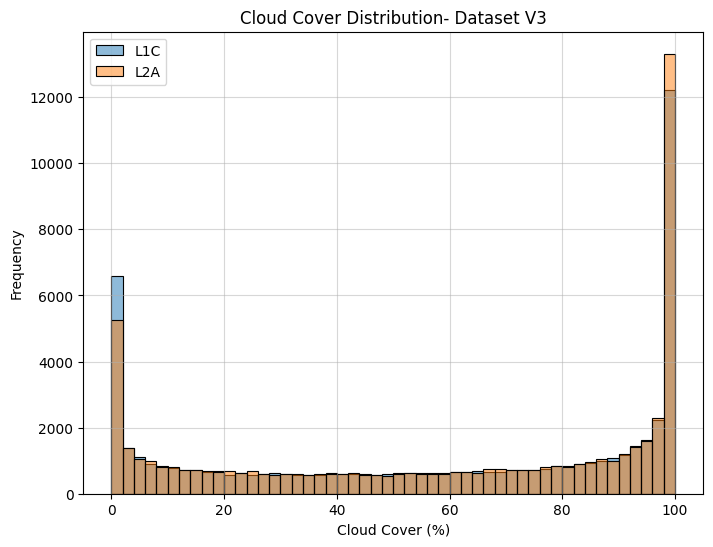

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms of cloud_cover
plt.figure(figsize=(8, 6))
sns.histplot(df_input['cloud_cover'], bins=50, label='L1C', alpha=0.5)
sns.histplot(df_target['cloud_cover'], bins=50,label='L2A', alpha=0.5)
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Frequency')
plt.title(f'Cloud Cover Distribution- Dataset {DATASET_VERSION}')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

In [7]:
df = df_target[df_target['cloud_cover']>90].sample(n=1400, random_state=42)

Using 1426 samples per bin based on minimum available


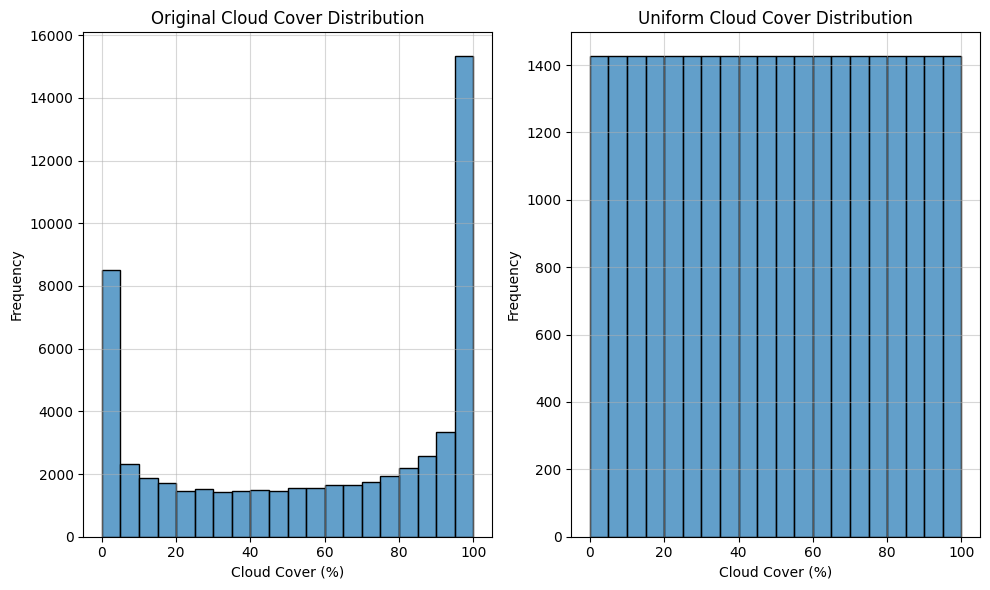

Original dataset size: 56811
Uniform dataset size: 28520


In [8]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

def create_uniform_cloud_cover_distribution(df_input, df_target, num_bins=10, samples_per_bin=None):
    """
    Create datasets with uniform cloud cover distribution

    Args:
        df_input: Input dataframe
        df_target: Target dataframe
        num_bins: Number of bins to divide the cloud cover range (0-100%)
        samples_per_bin: Number of samples to select per bin (if None, uses minimum available)

    Returns:
        Filtered input and target dataframes with uniform cloud cover distribution
    """
    # Create bins for cloud cover
    bin_edges = np.linspace(0, 100, num_bins+1)

    # Initialize empty dataframes for uniform distribution datasets
    uniform_input = pd.DataFrame()
    uniform_target = pd.DataFrame()

    # Track samples per bin
    bin_counts = []

    # First pass to determine minimum samples across bins if samples_per_bin isn't specified
    if samples_per_bin is None:
        for i in range(len(bin_edges)-1):
            bin_start = bin_edges[i]
            bin_end = bin_edges[i+1]

            # Count samples in this bin
            bin_samples = len(df_input[(df_input['cloud_cover'] >= bin_start) &
                                       (df_input['cloud_cover'] < bin_end)])
            bin_counts.append(bin_samples)

        samples_per_bin = min(bin_counts)
        print(f"Using {samples_per_bin} samples per bin based on minimum available")

    # Process each bin
    for i in range(len(bin_edges)-1):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i+1]

        # Filter indices for samples in current bin
        bin_indices = df_input[(df_input['cloud_cover'] >= bin_start) &
                               (df_input['cloud_cover'] < bin_end)].index.tolist()

        # Skip if no samples in this bin
        if not bin_indices:
            print(f"Warning: No samples in bin {bin_start}-{bin_end}")
            continue

        # If we have fewer samples than needed, use all with replacement
        if len(bin_indices) < samples_per_bin:
            # Resample with replacement
            selected_indices = random.choices(bin_indices, k=samples_per_bin)
        else:
            # Randomly select indices without replacement
            selected_indices = random.sample(bin_indices, samples_per_bin)

        # Add selected samples to the uniform datasets
        uniform_input = pd.concat([uniform_input, df_input.loc[selected_indices]])
        uniform_target = pd.concat([uniform_target, df_target.loc[selected_indices]])

    return uniform_input, uniform_target

# Apply the function to create uniformly distributed datasets
# You can adjust num_bins for finer granularity and samples_per_bin for dataset size
num_bins = 20  # 5% cloud cover range per bin
uniform_df_input, uniform_df_target = create_uniform_cloud_cover_distribution(
    df_input, df_target, num_bins=num_bins)

# Plot to verify uniform distribution
plt.figure(figsize=(10, 6))

# Original distribution
plt.subplot(1, 2, 1)
sns.histplot(df_input['cloud_cover'], bins=num_bins, label='Original', alpha=0.7)
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Frequency')
plt.title('Original Cloud Cover Distribution')
plt.grid(True, alpha=0.5)

# Uniform distribution
plt.subplot(1, 2, 2)
sns.histplot(uniform_df_input['cloud_cover'], bins=num_bins, label='Uniform', alpha=0.7)
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Frequency')
plt.title('Uniform Cloud Cover Distribution')
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Original dataset size: {len(df_input)}")
print(f"Uniform dataset size: {len(uniform_df_input)}")

In [9]:
uniform_df_input = uniform_df_input.reset_index(drop=True)

In [10]:
uniform_df_target = uniform_df_target.reset_index(drop=True)

In [11]:
for i in range(min(len(uniform_df_input), len(uniform_df_target))):
    if uniform_df_input['id_key'][i] == uniform_df_target['id_key'][i]:
        print(f"Match: {uniform_df_input['id_key'][i]} == {uniform_df_target['id_key'][i]}")
    else:
        print(f"Mismatch: {uniform_df_input['id_key'][i]} != {uniform_df_target['id_key'][i]}")

Match: S2A_MSIL1C_20190626T102031_N0500_R065_T32UNU == S2A_MSIL1C_20190626T102031_N0500_R065_T32UNU
Match: S2B_MSIL1C_20190617T104029_N0500_R008_T31TGL == S2B_MSIL1C_20190617T104029_N0500_R008_T31TGL
Match: S2A_MSIL1C_20230926T102801_N0509_R108_T31UFP == S2A_MSIL1C_20230926T102801_N0509_R108_T31UFP
Match: S2A_MSIL1C_20211112T102251_N0500_R065_T32TLS == S2A_MSIL1C_20211112T102251_N0500_R065_T32TLS
Match: S2B_MSIL1C_20230928T101719_N0509_R065_T32UMA == S2B_MSIL1C_20230928T101719_N0509_R065_T32UMA
Match: S2A_MSIL1C_20210903T102021_N0500_R065_T32UMU == S2A_MSIL1C_20210903T102021_N0500_R065_T32UMU
Match: S2A_MSIL1C_20180419T101031_N0500_R022_T32UPU == S2A_MSIL1C_20180419T101031_N0500_R022_T32UPU
Match: S2A_MSIL1C_20230303T103931_N0509_R008_T31UFQ == S2A_MSIL1C_20230303T103931_N0509_R008_T31UFQ
Match: S2B_MSIL1C_20220919T103639_N0400_R008_T31TFL == S2B_MSIL1C_20220919T103639_N0400_R008_T31TFL
Match: S2B_MSIL1C_20240316T101649_N0510_R065_T32TMR == S2B_MSIL1C_20240316T101649_N0510_R065_T32TMR


In [12]:
uniform_df_input.head(5)

,id_key,Name,S3Path,Footprint,GeoFootprint,cloud_cover
0,S2A_MSIL1C_20190626T102031_N0500_R065_T32UNU,S2A_MSIL1C_20190626T102031_N0500_R065_T32UNU_2...,/eodata/Sentinel-2/MSI/L1C_N0500/2019/06/26/S2...,geography'SRID=4326;POLYGON ((8.99973199721401...,"{'type': 'Polygon', 'coordinates': [[[8.999731...",0.000000
1,S2B_MSIL1C_20190617T104029_N0500_R008_T31TGL,S2B_MSIL1C_20190617T104029_N0500_R008_T31TGL_2...,/eodata/Sentinel-2/MSI/L1C_N0500/2019/06/17/S2...,geography'SRID=4326;POLYGON ((6.35433508851796...,"{'type': 'Polygon', 'coordinates': [[[6.354335...",0.100094
2,S2A_MSIL1C_20230926T102801_N0509_R108_T31UFP,S2A_MSIL1C_20230926T102801_N0509_R108_T31UFP_2...,/eodata/Sentinel-2/MSI/L1C/2023/09/26/S2A_MSIL...,geography'SRID=4326;POLYGON ((5.54611025590526...,"{'type': 'Polygon', 'coordinates': [[[5.546110...",0.000000
3,S2A_MSIL1C_20211112T102251_N0500_R065_T32TLS,S2A_MSIL1C_20211112T102251_N0500_R065_T32TLS_2...,/eodata/Sentinel-2/MSI/L1C_N0500/2021/11/12/S2...,geography'SRID=4326;POLYGON ((7.43831408505682...,"{'type': 'Polygon', 'coordinates': [[[7.438314...",1.147757
4,S2B_MSIL1C_20230928T101719_N0509_R065_T32UMA,S2B_MSIL1C_20230928T101719_N0509_R065_T32UMA_2...,/eodata/Sentinel-2/MSI/L1C/2023/09/28/S2B_MSIL...,geography'SRID=4326;POLYGON ((8.75425488029242...,"{'type': 'Polygon', 'coordinates': [[[8.754254...",0.445110


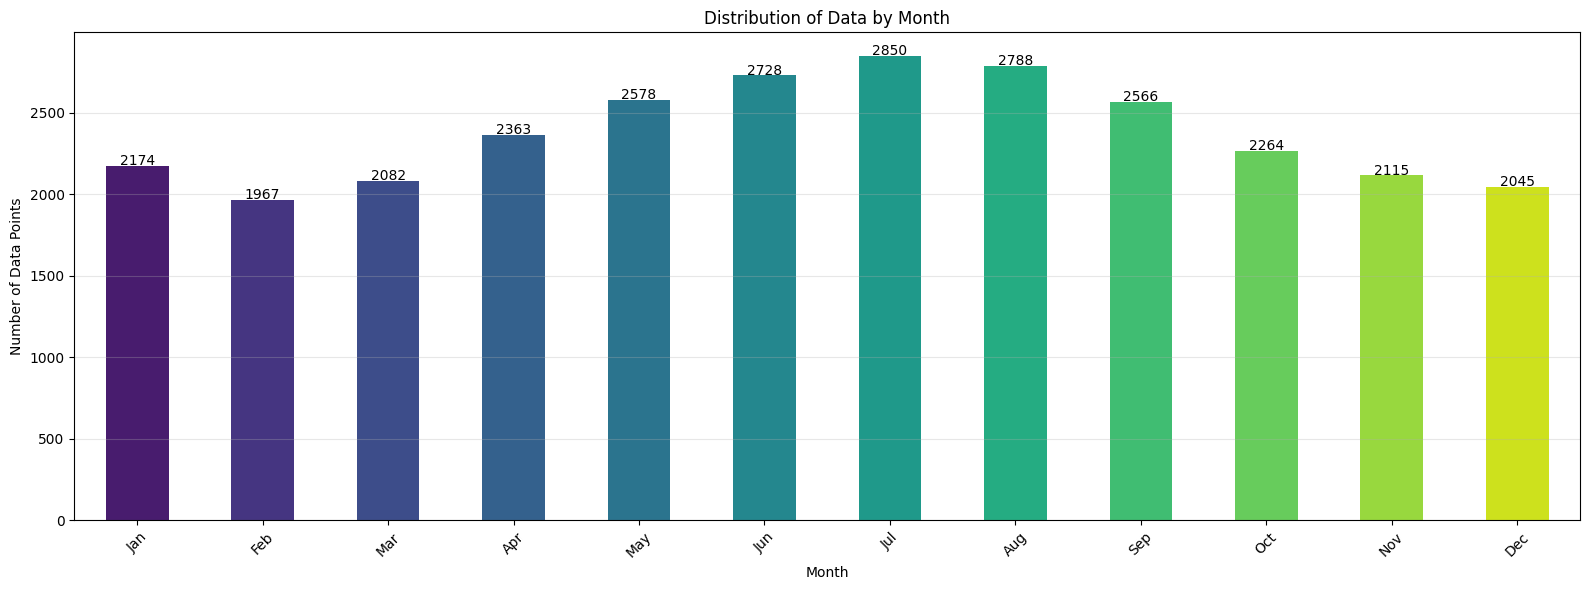

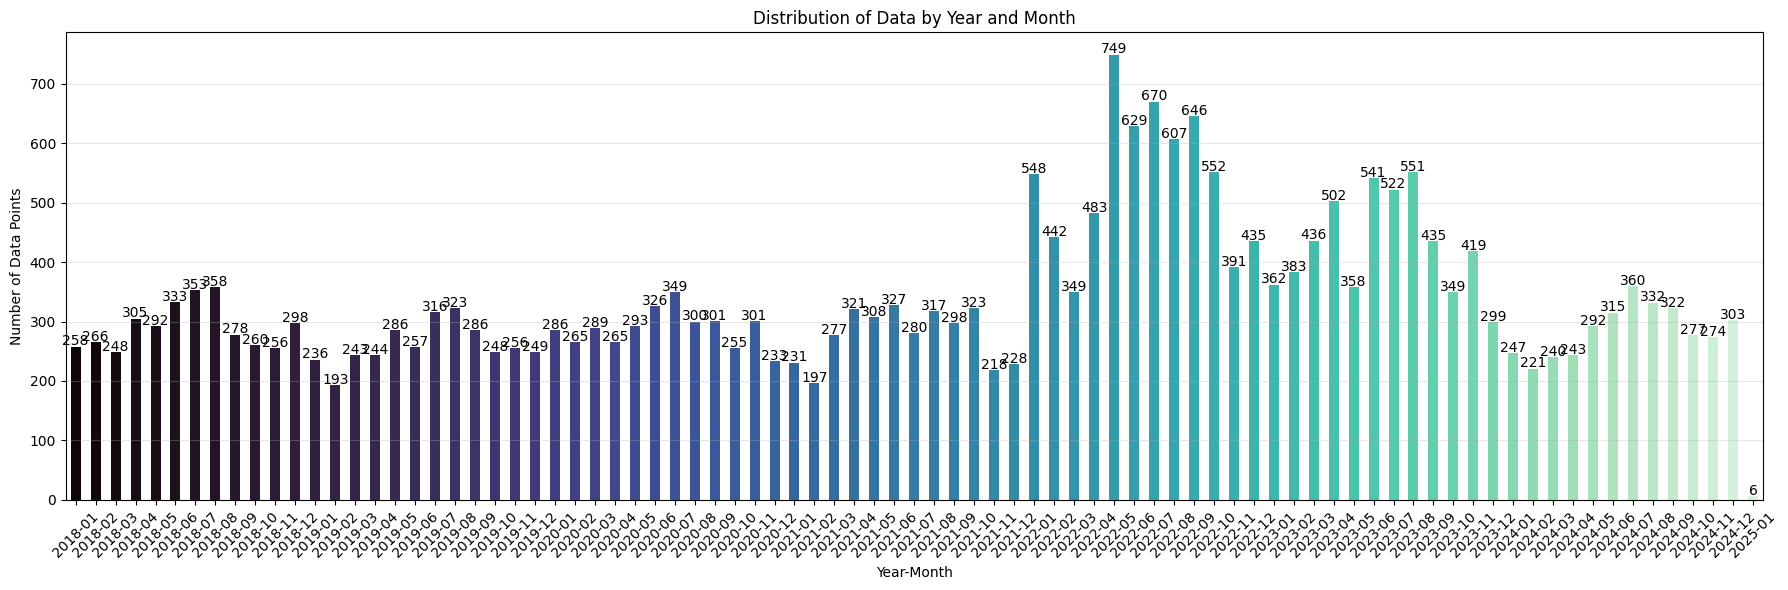

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

# Extract date from id_key
def extract_date_from_id(id_key):
    """Extract the date part (YYYYMMDD) from Sentinel-2 ID string"""
    match = re.search(r'_(\d{8})T', id_key)
    if match:
        return match.group(1)
    return None

# Apply the extraction to the dataframe
uniform_df_input['date_str'] = uniform_df_input['id_key'].apply(extract_date_from_id)

# Convert to datetime and extract month information
uniform_df_input['date'] = pd.to_datetime(uniform_df_input['date_str'], format='%Y%m%d')
uniform_df_input['month'] = uniform_df_input['date'].dt.month
uniform_df_input['month_name'] = uniform_df_input['date'].dt.strftime('%b')
uniform_df_input['year_month'] = uniform_df_input['date'].dt.strftime('%Y-%m')

# Create a count of data points by month
monthly_counts = uniform_df_input['month_name'].value_counts().sort_index()

# Sort the months in chronological order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_counts = monthly_counts.reindex(month_order)

# Create a bar plot for data counts per month
plt.figure(figsize=(16, 6))
monthly_counts.plot(kind='bar', color=sns.color_palette("viridis", len(monthly_counts)))
plt.xlabel('Month')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data by Month')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of bars
for i, count in enumerate(monthly_counts):
    plt.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

# For a more detailed view, you could also plot by year-month
# (if your data spans multiple years)
yearly_monthly_counts = uniform_df_input['year_month'].value_counts().sort_index()

plt.figure(figsize=(18, 6))
yearly_monthly_counts.plot(kind='bar', color=sns.color_palette("mako", len(yearly_monthly_counts)))
plt.xlabel('Year-Month')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data by Year and Month')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of bars
for i, count in enumerate(yearly_monthly_counts):
    plt.text(i, count + 2, str(count), ha='center')

plt.tight_layout()
plt.show()


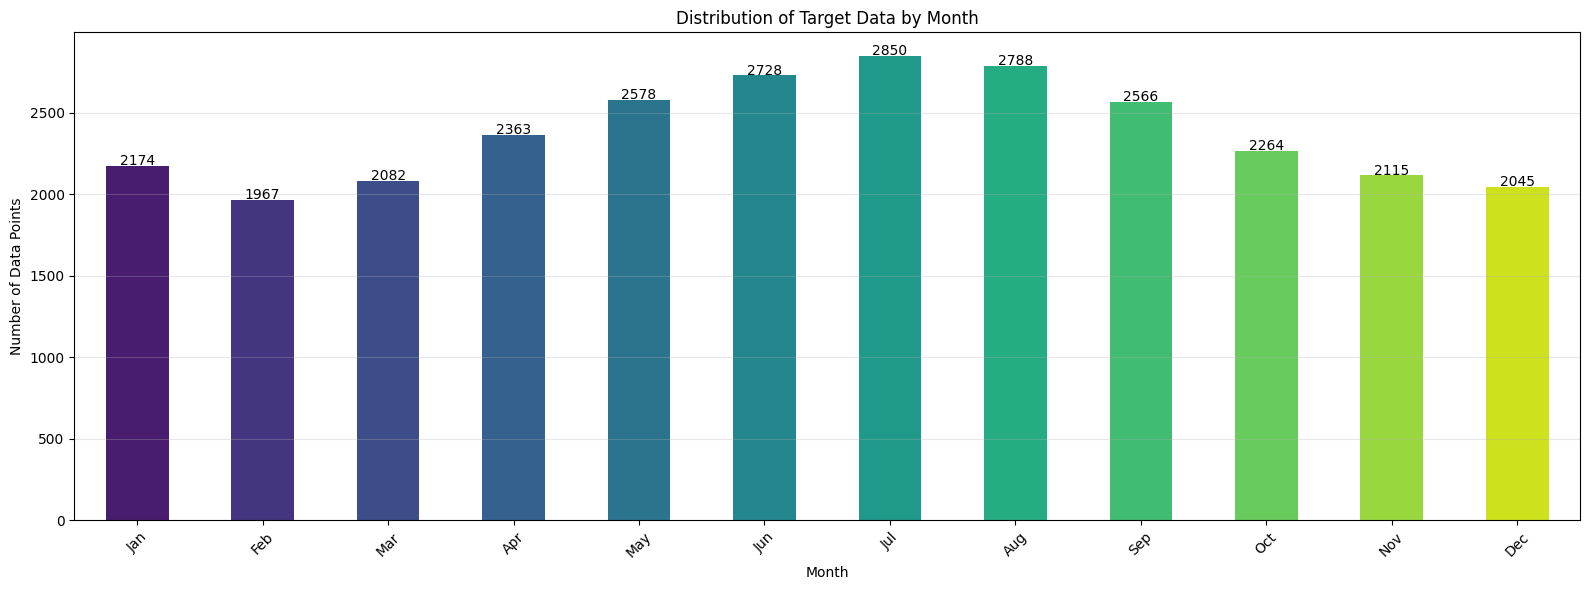

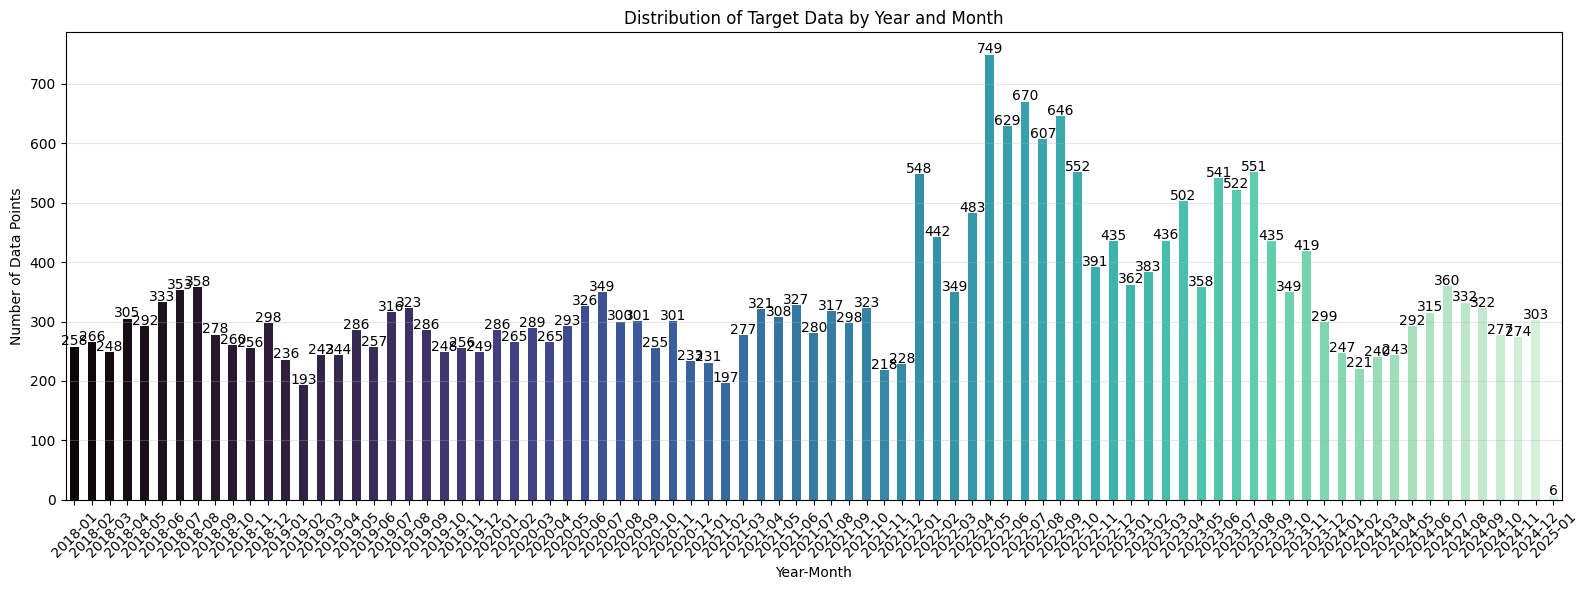

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

# Extract date from id_key
def extract_date_from_id(id_key):
    """Extract the date part (YYYYMMDD) from Sentinel-2 ID string"""
    match = re.search(r'_(\d{8})T', id_key)
    if match:
        return match.group(1)
    return None

# Apply the extraction to the target dataframe
uniform_df_target['date_str'] = uniform_df_target['id_key'].apply(extract_date_from_id)

# Convert to datetime and extract month information
uniform_df_target['date'] = pd.to_datetime(uniform_df_target['date_str'], format='%Y%m%d')
uniform_df_target['month'] = uniform_df_target['date'].dt.month
uniform_df_target['month_name'] = uniform_df_target['date'].dt.strftime('%b')
uniform_df_target['year_month'] = uniform_df_target['date'].dt.strftime('%Y-%m')

# Create a count of data points by month
monthly_counts = uniform_df_target['month_name'].value_counts().sort_index()

# Sort the months in chronological order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_counts = monthly_counts.reindex(month_order)

# Create a bar plot for data counts per month
plt.figure(figsize=(16, 6))
monthly_counts.plot(kind='bar', color=sns.color_palette("viridis", len(monthly_counts)))
plt.xlabel('Month')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Target Data by Month')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of bars
for i, count in enumerate(monthly_counts):
    plt.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

# For a more detailed view, you could also plot by year-month
# (if your data spans multiple years)
yearly_monthly_counts = uniform_df_target['year_month'].value_counts().sort_index()

plt.figure(figsize=(16, 6))
yearly_monthly_counts.plot(kind='bar', color=sns.color_palette("mako", len(yearly_monthly_counts)))
plt.xlabel('Year-Month')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Target Data by Year and Month')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of bars
for i, count in enumerate(yearly_monthly_counts):
    plt.text(i, count + 2, str(count), ha='center')

plt.tight_layout()
plt.show()

Split data into:
  Training:   22816 samples (80.0%)
  Validation: 2852 samples (10.0%)
  Test:       2852 samples (10.0%)


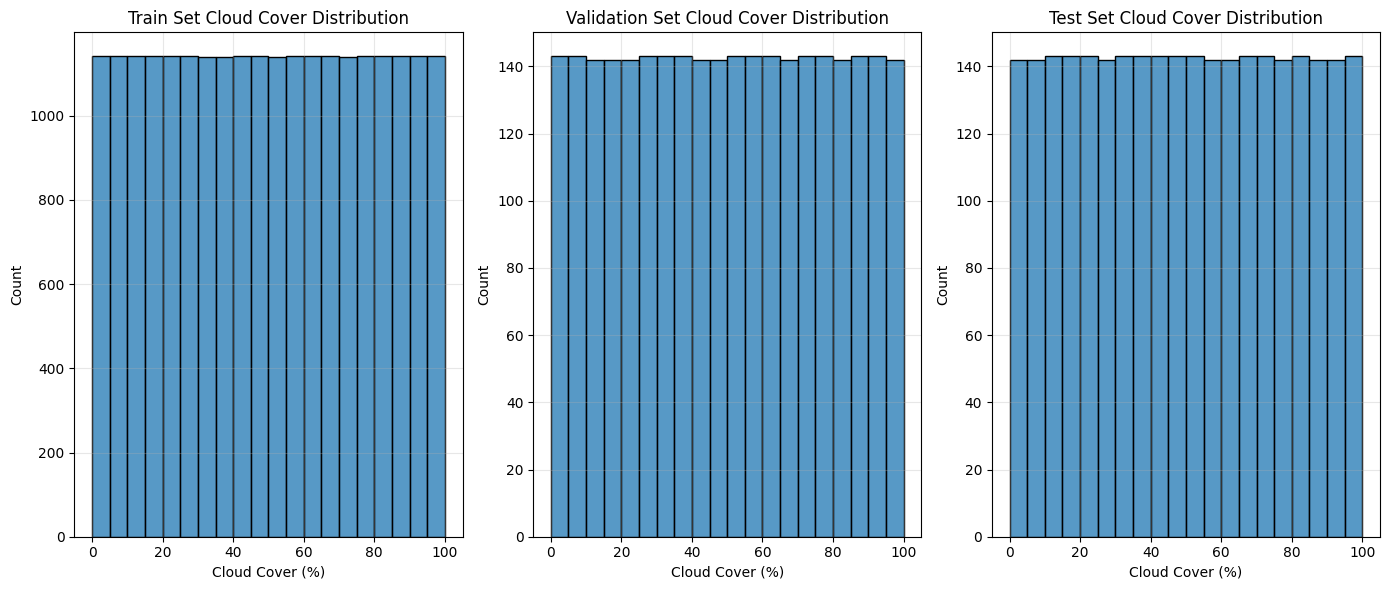

<Figure size 1400x600 with 0 Axes>

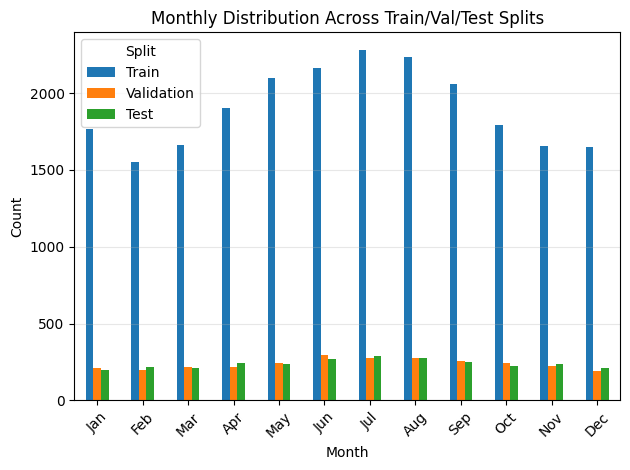

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def split_dataset_stratified_by_cloud_cover(df_input, df_target, train_size=0.7, val_size=0.15, test_size=0.15, num_bins=10, random_state=42):
    """
    Split dataset into train/val/test while preserving cloud cover distribution

    Args:
        df_input: Input dataframe
        df_target: Target dataframe
        train_size: Proportion for training set (default 0.7)
        val_size: Proportion for validation set (default 0.15)
        test_size: Proportion for test set (default 0.15)
        num_bins: Number of bins to divide cloud cover for stratification
        random_state: Random seed for reproducibility

    Returns:
        Six dataframes: input_train, input_val, input_test, target_train, target_val, target_test
    """
    assert np.isclose(train_size + val_size + test_size, 1.0), "Split proportions must sum to 1.0"

    # Create cloud cover bins for stratification
    df_input['cloud_cover_bin'] = pd.cut(df_input['cloud_cover'], bins=num_bins, labels=False)

    # First split: train and temp (val+test combined)
    temp_size = val_size + test_size
    relative_val_size = val_size / temp_size  # For the second split

    input_train, input_temp, target_train, target_temp = train_test_split(
        df_input, df_target,
        train_size=train_size,
        stratify=df_input['cloud_cover_bin'],
        random_state=random_state
    )

    # Second split: divide temp into val and test
    input_val, input_test, target_val, target_test = train_test_split(
        input_temp, target_temp,
        train_size=relative_val_size,
        stratify=input_temp['cloud_cover_bin'],
        random_state=random_state
    )

    # Drop the stratification column
    input_train = input_train.drop('cloud_cover_bin', axis=1)
    input_val = input_val.drop('cloud_cover_bin', axis=1)
    input_test = input_test.drop('cloud_cover_bin', axis=1)

    # Report split sizes
    print(f"Split data into:")
    print(f"  Training:   {len(input_train)} samples ({len(input_train)/len(df_input):.1%})")
    print(f"  Validation: {len(input_val)} samples ({len(input_val)/len(df_input):.1%})")
    print(f"  Test:       {len(input_test)} samples ({len(input_test)/len(df_input):.1%})")

    return input_train, input_val, input_test, target_train, target_val, target_test

# Perform the split
input_train, input_val, input_test, target_train, target_val, target_test = split_dataset_stratified_by_cloud_cover(
    uniform_df_input, uniform_df_target,
    train_size=0.8, val_size=0.10, test_size=0.10,
    num_bins=20, random_state=42
)

# Visualize cloud cover distribution across splits
plt.figure(figsize=(14, 6))

# Plot histograms for each split
plt.subplot(1, 3, 1)
sns.histplot(input_train['cloud_cover'], bins=20)
plt.title('Train Set Cloud Cover Distribution')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Count')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
sns.histplot(input_val['cloud_cover'], bins=20)
plt.title('Validation Set Cloud Cover Distribution')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Count')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
sns.histplot(input_test['cloud_cover'], bins=20)
plt.title('Test Set Cloud Cover Distribution')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Count')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Compare month distribution across splits
def plot_monthly_distribution_by_split(train_df, val_df, test_df, title='Monthly Distribution by Split'):
    """Plot monthly distribution across train/val/test splits"""
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    train_months = train_df['month_name'].value_counts().reindex(month_order).fillna(0)
    val_months = val_df['month_name'].value_counts().reindex(month_order).fillna(0)
    test_months = test_df['month_name'].value_counts().reindex(month_order).fillna(0)

    # Combine into a DataFrame for plotting
    monthly_dist = pd.DataFrame({
        'Train': train_months,
        'Validation': val_months,
        'Test': test_months
    })

    # Plot
    plt.figure(figsize=(14, 6))
    monthly_dist.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Split')
    plt.tight_layout()
    plt.show()

    return monthly_dist

# Plot monthly distribution
monthly_dist = plot_monthly_distribution_by_split(
    input_train, input_val, input_test,
    title='Monthly Distribution Across Train/Val/Test Splits'
)

# Optional: Save the splits to disk
def save_splits(input_train, input_val, input_test, target_train, target_val, target_test, base_path='./data/splits/'):
    """Save the data splits to disk"""
    import os
    os.makedirs(base_path, exist_ok=True)

    # Save input datasets
    input_train.to_csv(f"{base_path}input_train.csv", index=False)
    input_val.to_csv(f"{base_path}input_val.csv", index=False)
    input_test.to_csv(f"{base_path}input_test.csv", index=False)

    # Save target datasets
    target_train.to_csv(f"{base_path}target_train.csv", index=False)
    target_val.to_csv(f"{base_path}target_val.csv", index=False)
    target_test.to_csv(f"{base_path}target_test.csv", index=False)

    print(f"Splits saved to {base_path}")

# Uncomment to save the splits
# save_splits(input_train, input_val, input_test, target_train, target_val, target_test)
